In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from torchvision.utils import make_grid


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd"drive/MyDrive/"

/content/drive/MyDrive


In [4]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 28, 64)):

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# **Without Re-writing The Classifier And The Generator Clases The Code Keeps Breaking when re-loading them:**

In [5]:
class Generator(nn.Module):


  def __init__(self, z_dim=100, nodes=64):
      super(Generator, self).__init__()
      self.z_dim = z_dim
      self.gen = nn.Sequential(
          # input =z_dimx1x1
          nn.ConvTranspose2d(z_dim, nodes*4 , 3 , stride=2),
          nn.BatchNorm2d(nodes*4),
          nn.ReLU(),
          # output = 3x3

          nn.ConvTranspose2d(nodes*4 , nodes*2 , 4, stride=1),
          nn.BatchNorm2d(nodes*2 ),
          nn.ReLU(),
          # output =6x6

          nn.ConvTranspose2d(nodes*2, nodes , 3, stride=2),
          nn.BatchNorm2d(nodes),
          nn.ReLU(),
          # output =13x13

          nn.ConvTranspose2d(nodes, ch, 4, stride=2),
          nn.Tanh(),
          # output =28x28

      )

  def unsqueeze_noise(self, noise):
    return noise.view(len(noise), self.z_dim, 1, 1)

  def forward(self, noise):
    x = self.unsqueeze_noise(noise)
    return self.gen(x)
    

In [6]:
Generator = torch.load("gen.pt")
Generator.eval()

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (10): Tanh()
  )
)

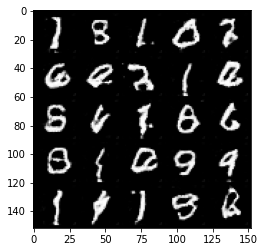

In [7]:
torch.manual_seed(524)
noise=torch.randn(64,100)
fake = Generator(noise)
show_tensor_images(fake,25)
xasd=3+3

In [8]:
class Discriminator(nn.Module):

    def __init__(self, nodes=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
          nn.Conv2d(ch, nodes, 4, stride=2),
          nn.BatchNorm2d(nodes),
          nn.ReLU(),
           # output =13x13
          nn.Conv2d(nodes, nodes *2, 4, stride=2),
          nn.BatchNorm2d(nodes *2),
          nn.ReLU(),
          # output =5x5
          nn.Conv2d(nodes *2, 1, 4, stride=2),
          # output =1x1
        )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [9]:
classifier = torch.load("zeror classifier.pt")
classifier.eval()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

# **Small Test For Fun:**

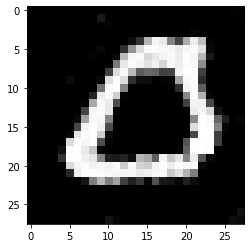

In [10]:
torch.manual_seed(43)
#generate noise vector
noise=torch.randn(155,100)
#get the generators predictions
fake = Generator(noise)
#the classifiers predictions are positive numbers when the image is a 0 and negative when it is not ,
# so i'm taking the maximum value to show what the classifier thinks this is the most realistic looking zero
zero=torch.argmax(classifier(fake))
c=classifier(fake[zero].reshape(1,1,28,28))
# plotting the image
ten=fake[zero].detach()
plt.imshow(ten.permute(1, 2, 0).squeeze(),cmap='gray')

# **Training:**

In [11]:
opt = torch.optim.Adam(classifier.parameters(), lr=0.01)
def calculate_updated_noise(noise, weight):
    new_noise=noise+(noise.grad*weight)
    return new_noise

In [12]:
n_images = 26
fake_image_history = []

# Number of gradient steps to take
grad_steps = 55 
torch.manual_seed(12)

noise=torch.randn(n_images,100).requires_grad_()

for i in range(grad_steps):
    opt.zero_grad()
    fake = Generator(noise)
    fake_image_history += [fake]
    # calculating the Loss
    fake_classes_score = classifier(fake).mean()
    #calculating the gradient
    fake_classes_score.backward()
    #Updating the gradient
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

# **Creating the gif image:**

In [13]:
def grid_images(image_tensor, num_images=25):

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    return image_grid.permute(1, 2, 0).squeeze()
    
x=torch.empty(0,152,152,3)
for i in fake_image_history:
  t=grid_images(i)
  x=torch.cat((t.reshape(1,152,152,3),x),dim=0)
 

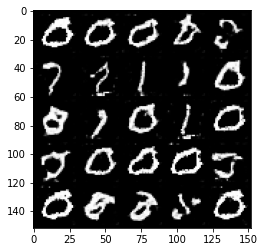

In [14]:
import matplotlib.animation as animation
fig = plt.figure() 

ims = []
for j in range(len(x)-1,-1,-1):
    im = plt.imshow(x[j],animated=True)
    ims.append([im])
anim  = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000,repeat = True)

anim.save('morphing_numbers.mp4')
plt.show()